In [ ]:
##References

#https://medium.com/@mirzezadeh.elvin/neural-style-transfer-with-deep-vgg-model-26b11ea06b7e

#https://github.com/elvinmirzazada/StyleTransfer_NerualNet/blob/master/Style_Transfer.ipynb

In [ ]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
 42%|████▏     | 228M/548M [00:01<00:03, 108MB/s]

In [ ]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
vgg.to(device)

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [ ]:
# load in content and style image
content = load_image('content.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('style.jpg', shape=content.shape[-2:]).to(device)

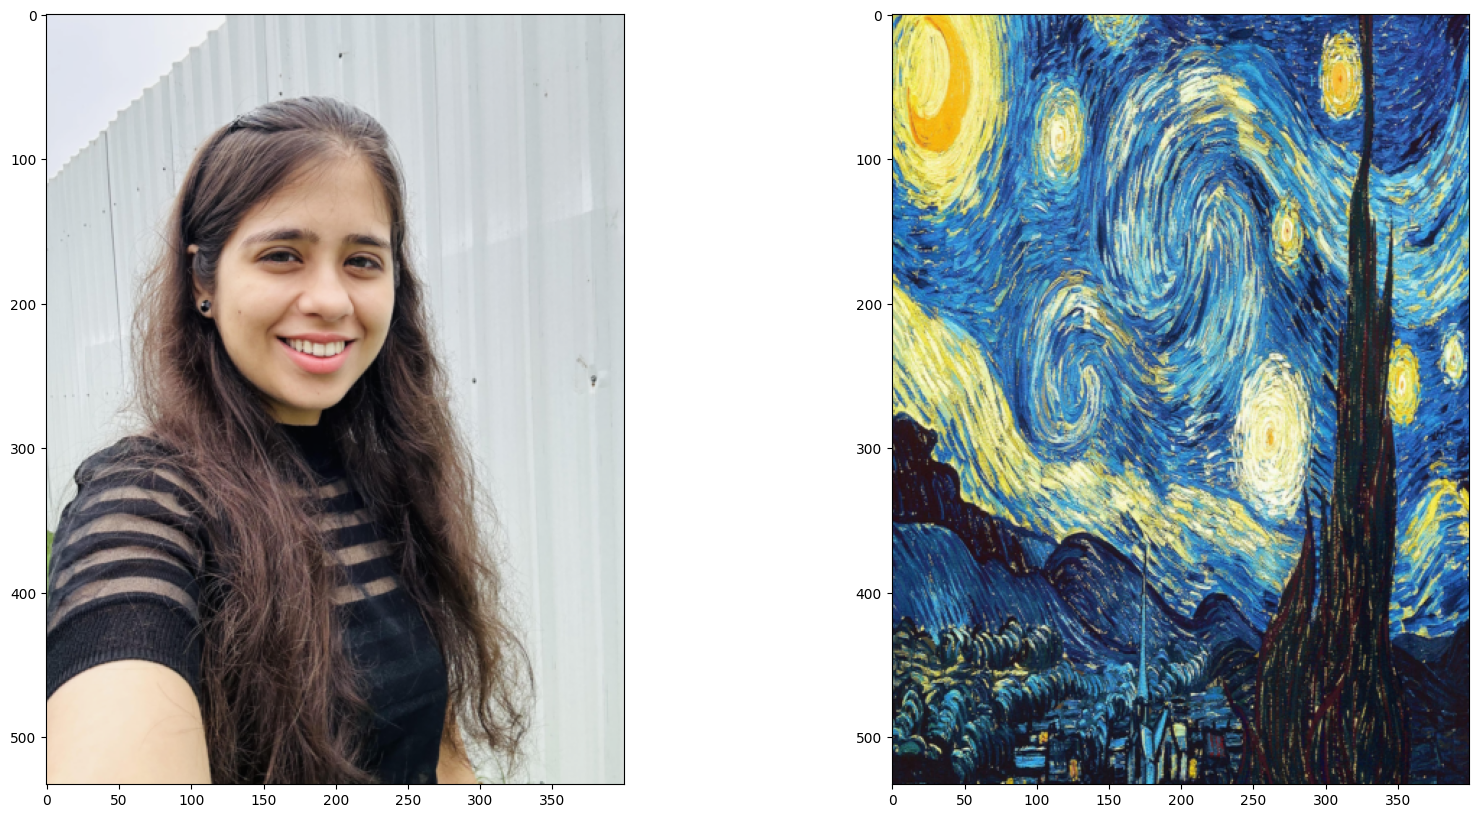

In [ ]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    gram = None
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 0.6  # alpha
style_weight = 1e1  # beta

In [ ]:
losses = {'content_loss':[],'style_loss':[],'total_loss':[],'iter':[]}

Total loss:  87140.34375


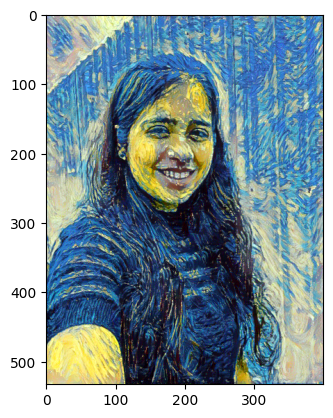

Total loss:  86394.4609375


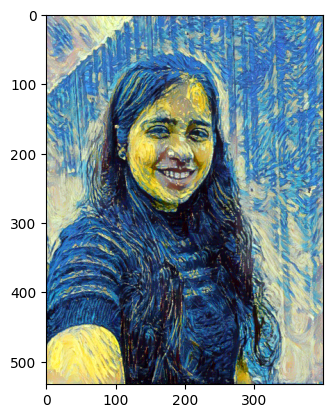

Total loss:  84743.1953125


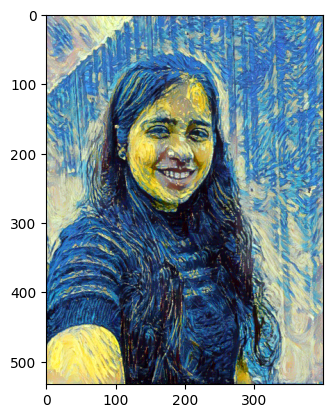

Total loss:  83325.171875


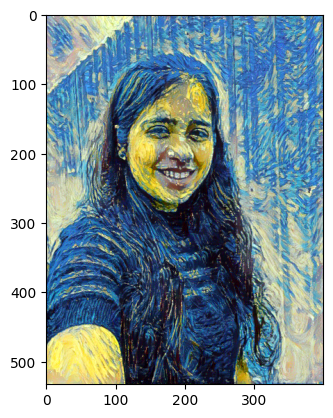

In [ ]:
# for displaying the target image, intermittently
show_every = 100

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 4000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    ## Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    losses['total_loss'].append(total_loss)
    losses['content_loss'].append(content_loss)
    losses['style_loss'].append(style_loss)
    losses['iter'].append(ii)
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print("Iteration is "+str(ii))
        plt.imshow(im_convert(target))
        plt.show()

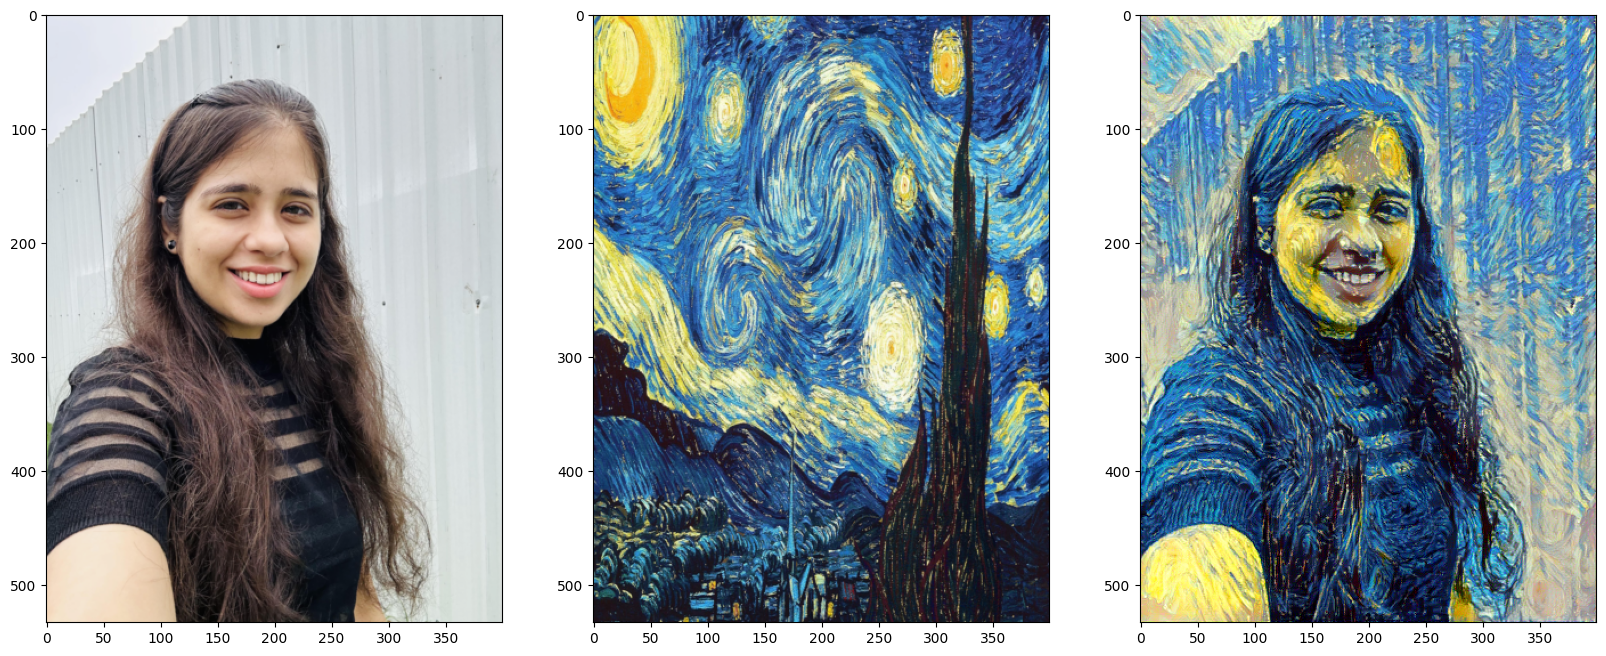

In [ ]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))

In [ ]:
import pandas as pd


In [ ]:

def to_float(ip):
    ip = float(ip)
    return ip



# Calling double method on each integer
# in list using list comprehension.

losses_p = {}
losses_p['content_loss_float'] = [to_float(i) for i in losses['content_loss']]
losses_p['style_loss_float'] = [to_float(i) for i in losses['style_loss']]
losses_p['total_loss_float'] = [to_float(i) for i in losses['total_loss']]
losses_p['iter'] = losses['iter']

In [ ]:
df_l = pd.DataFrame(losses_p)

In [ ]:
df_l

content_loss_float  style_loss_float  total_loss_float  iter
0              10.921726          0.420218      4.202246e+05     1
1              10.735174          1.266025      1.266032e+06     2
2              10.871196          0.471077      4.710835e+05     3
3              10.995435          0.614787      6.147931e+05     4
4              11.039510          0.866088      8.660950e+05     5
...                  ...               ...               ...   ...
3995           11.440405          0.083046      8.305276e+04  3996
3996           11.443856          0.083041      8.304765e+04  3997
3997           11.439131          0.083067      8.307355e+04  3998
3998           11.445582          0.083151      8.315781e+04  3999
3999           11.437150          0.083318      8.332517e+04  4000

[4000 rows x 4 columns]

In [ ]:
import plotly.express as px


ys = ['content_loss_float','style_loss_float',
                                    'total_loss_float']
fig = px.scatter(df_l, x='iter', y=ys[0],
                 color_discrete_sequence=['blue'],
                 labels={'value': 'Values'}, title='Scatter Plot')

# Show the plot
fig.show()




In [ ]:
fig = px.scatter(df_l, x='iter', y=ys[1],
                 color_discrete_sequence=['blue'],
                 labels={'value': 'Values'}, title='Scatter Plot')

# Show the plot
fig.show()

In [ ]:
fig = px.scatter(df_l, x='iter', y=ys[2],
                 color_discrete_sequence=['blue'],
                 labels={'value': 'Values'}, title='Scatter Plot')

# Show the plot
fig.show()